# Project 4 - Train a Smartcab to Drive

## Implement a Basic Driving Agent

To begin, your only task is to get the smartcab to move around in the environment. At this point, you will not be concerned with any sort of optimal driving policy.

To complete this task, simply have your driving agent choose a random action from the set of possible actions (None, `'forward'`, `'left'`, `'right'`) at each intersection. Set the simulation deadline enforcement, **`enforce_deadline`** to **`False`** and observe how it performs.

### Code Snippet:
``` Python
def random_action(self):
    from random import choice
    return choice([None, 'forward', 'left', 'right'])
```

### Question 1:

**Observe what you see with the agent's behavior as it takes random actions. Does the smartcab eventually make it to the destination? Are there any other interesting observations to note?**

1. In almost 65% of the trials, the smartcab eventually makes it to the destination within the hard time limit (-100).
2. Other observations that were not mentioned in the problem statement:
    1. The agent seems to never reach the destination within the time limit (it always goes to negative time)
    2. Environment wrap around itself (East-most connected to West-most, and North-most connected to South-most.)
    3. Disobeying traffic lows results in -1 rewards, and the action is not performed
    4. Reaching the goal results in +10 rewards
    5. Performing a legal move results in either +2 or -0.5 (by looking at the code, I figured it is based on whether the smartcab followed the `next_waypoint` suggestion by the planner or not)
    
    

## Inform the Driving Agent

Now that your driving agent is capable of moving around in the environment, your next task is to identify a set of states that are appropriate for modeling the smartcab and environment.

The main source of state variables are the current inputs at the intersection, but not all may require representation. You may choose to explicitly define states, or use some combination of inputs as an implicit state.

At each time step, process the inputs and update the agent's current state using the `self.state` variable. Continue with the simulation deadline enforcement `enforce_deadline` being set to `False`, and observe how your driving agent now reports the change in state as the simulation progresses.

### Code Snippet

``` Python
def eval_state(self, next_waypoint, inputs):
    return {'next_waypoint': next_waypoint,
            'light': inputs['light'],
            'right': inputs['right'],
            'oncoming': inputs['oncoming'],
            'left': inputs['left']}
```

### Question 2:

**What states have you identified that are appropriate for modeling the smartcab and environment? Why do you believe each of these states to be appropriate for this problem?**

1. I was able to identify five states that would model the smarcab and the environment:
    1. `next_waypoint`: To represent the direction suggested by the planner
    2. `light`: To represent the state of traffic light
    3. `right`: To represent the state of car(s) coming from the right side at the intersection
    4. `oncoming`: To represent the state of car(s) coming from the oncoming side at the intersection
    5. `left`: To represent the state of car(s) coming from the left side at the intersection
    
2. Appropriateness of these states were achieved by:
    1. `next_waypoint`: Since the `next_waypoint` affects the reward that would be achieved at each state, it is important to have it as part of our state as a representation of the smartcab planner
    2. `light`: Since the traffic light gives an important infromation about the traffic low at the intersection, it is important to be represented
    3. `right`, `oncoming`, and `left`: Since the existance of cars at the intersection usually changes the traffic, it is important for these values to be represented. One could argue that these three data could be combined (Ex: Combine `oncoming-left` with `left-forward`), or maybe their values could be reduced (Ex: instead of `oncoming` having four values, it could be reduced to `true/false`). Some could argue also that one of them could be dropped (Ex: dropping `right`). However, all these arguments are based on the traffic law explained in the question. If you take the car to a country where people drive at the left side of the road (Ex: England), the auto-pilot will fail based on these assumptions. The auto-pilot should learn the traffic low purely based on the rewards without embedding law in the states.
    4. `deadline` is ignored by this representation of states because: 
        1. The purpose of the auto-pilot is to learn how to obey the planner and the traffic law. The deadline doesn't contribute to both. The planner and traffic law are both time-invariant
        2. More importantly, the deadline will make the auto-pilot thinks that it is in a new state when all other states are the same and the deadline is different. This would cause the auto-pilot to act as if it didn't see that state before even though changing the time doesn't affect how the agent should move in that state to achieve the most reward.
        

### Question 3:

**How many states in total exist for the smartcab in this environment? Does this number seem reasonable given that the goal of Q-Learning is to learn and make informed decisions about each state? Why or why not?**

1. Number of states that exist are `2 x 3 x 4 x 4 x 4 = 384` (`light` has two values, `next_waypoint` has three values, `right`, `oncoming`, and `left` has each four values. Note that the planner doesn't provide `None` as one of the suggested `next_waypoint`).

2. The number of states seems non-reasonable for a Q-Learning since it is high. These 384 states are combined with the 4 possible actions to give a possible space for the Q function which $1,536$. However, since most of these $384$ are rarely visited, the agent can still learn how to represent the planner and the traffic law.

## Implement a Q-Learning Driving Agent

With your driving agent being capable of interpreting the input information and having a mapping of environmental states, your next task is to implement the Q-Learning algorithm for your driving agent to choose the best action at each time step, based on the Q-values for the current state and action.

Each action taken by the smartcab will produce a reward which depends on the state of the environment. The Q-Learning driving agent will need to consider these rewards when updating the Q-values. Once implemented, set the simulation deadline enforcement `enforce_deadline` to `True`. Run the simulation and observe how the smartcab moves about the environment in each trial.

### Code Snippet

``` Python
def Q_action(self, state):
    actions = []
    best_score = self.Q.get((str(state), None), self.default_Q_value)
    for action in [None, 'forward', 'left', 'right']:
        val = self.Q.get((str(state), action), self.default_Q_value)
        if val < best_score - 1e-9:
            # Better action was found before
            continue
        elif val > best_score + 1e-9:
            # This is a better action than the one(s) found before
            actions = [action]
            best_score = val
        else:
            # This action produces the same best_score so far
            actions.append(action)

    from random import choice
    return choice(actions)

def explore_exploite_action(self):
    from random import random
    if random() < self.epsilon:
        # Exploration
        print "LearningAgent.explore_exploite_action(): Exploration" # [debug]
        return self.random_action()
    else:
        # Exploitation
        print "LearningAgent.explore_exploite_action(): Exploitation" # [debug]
        return self.Q_action(self.state)

def bellman(self, state, action, reward):
    new_next_waypoint = self.planner.next_waypoint()
    new_inputs = self.env.sense(self)
    new_state = self.eval_state(new_next_waypoint, new_inputs)
    new_action = self.Q_action(new_state)

    old_val = self.Q.get((str(state), action), self.default_Q_value)
    update_val = reward + self.gamma * self.Q.get((str(new_state), new_action), self.default_Q_value)

    return (1 - self.alpha) * old_val + self.alpha * update_val

def update(self, t):
    # Gather inputs
    self.next_waypoint = self.planner.next_waypoint()  # from route planner, also displayed by simulator
    inputs = self.env.sense(self)
    deadline = self.env.get_deadline(self)

    # TODO: Update state
    self.state = self.eval_state(self.next_waypoint, inputs)

    # TODO: Select action according to your policy
    action = self.explore_exploite_action()

    # Execute action and get reward
    reward = self.env.act(self, action)

    # TODO: Learn policy based on state, action, reward
    self.Q[(str(self.state), action)] = self.bellman(self.state, action, reward)
```

### Question 4:

**What changes do you notice in the agent's behavior when compared to the basic driving agent when random actions were always taken? Why is this behavior occurring?**

1. One major difference between the original behavior and the new one is that it can successfully reach the goal in more than 90% of the cases. Also, after the initial trials, the agent learns to obey the traffic law and the planner suggestions.

2. This behavior is emerging because the agent learns that obeying the law would result in more reward in the long run. Also, it learns that the planner takes it to the destination where even more reward is achieved. On the other hand, the random actions were resulting in negative rewards in several cases.

## Improve the Q-Learning Driving Agent

Your final task for this project is to enhance your driving agent so that, after sufficient training, the smartcab is able to reach the destination within the allotted time safely and efficiently. 

Parameters in the Q-Learning algorithm, such as the learning rate (**`alpha`**), the discount factor (**`gamma`**) and the exploration rate (**`epsilon`**) all contribute to the driving agent’s ability to learn the best action for each state.

To improve on the success of your smartcab:

- Set the number of trials, `n_trials`, in the simulation to 100.
- Run the simulation with the deadline enforcement `enforce_deadline` set to `True` (you will need to reduce the update delay `update_delay` and set the `display` to `False`).
- Observe the driving agent’s learning and smartcab’s success rate, particularly during the later trials.
- Adjust one or several of the above parameters and iterate this process.

This task is complete once you have arrived at what you determine is the best combination of parameters required for your driving agent to learn successfully.

### Question 5:

**Report the different values for the parameters tuned in your basic implementation of Q-Learning. For which set of parameters does the agent perform best? How well does the final driving agent perform?**

For `epsilon`, I used the following values: `[0.1, 0.5, 0.9]`. As for `alpha` and `gamma`, I used the following values: `[0.1, 0.2, 0.4, 0.6, 0.8, 1.0]`. Using these values, the code provided above was run over 100 trials and the success rate and average rewards are reported in the following heatmaps:

As we can see from the heatmaps below. `epsilon = 0.1` provides the best results. By looking at the two heatmaps for Average Rewards and Success Rates when `epsilon = 0.1`, we can try to pick an optimal choice for `alpha` and `gamma`.

There are three points of interest:

    1. [alpha = 0.1, gamma = 0.4]:
        This point provides the highest average reward of 28 points. This means that safety of passengers, following the law, and obeying the planner are at maximum in this point. However, there is a trade-off. Compared to other possible points, the success rate is lower at 86%.
    2. [alpha = 0.2, gamma = 0.2]:
        At the other end of the spectrum, this point has the highest success rate of 100%. However, it suffers from lower average reward of 23 points.
    3. [alpha = 0.2, gamma = 0.4]:
        This point has the best trade-off. It has high success rate of 94%. As well, the average reward is high (27 points) which means the agent is reaching the destination with high considration to the safety of the passengers, obeying the rules, and following the planner.


From this analysis, we can see that the optimal choices for the three parameters are: **`epsilon = 0.1`, `alpha = 0.2`, and `gamma = 0.4`**

#### Epsilon = 0.1

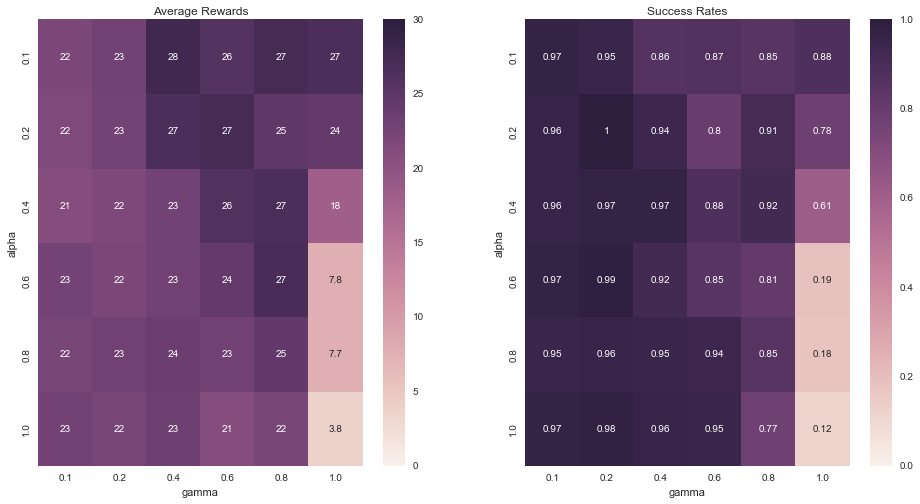

In [54]:
alpha_values = [0.1, 0.2, 0.4, 0.6, 0.8, 1.0]
gamma_values = [0.1, 0.2, 0.4, 0.6, 0.8, 1.0]
average_rewards = [[ 22.   ,  22.87 ,  27.795,  25.785,  27.405,  26.71 ],
                   [ 21.64 ,  22.735,  26.925,  27.27 ,  24.82 ,  24.395],
                   [ 21.05 ,  21.76 ,  22.95 ,  26.24 ,  26.785,  18.09 ],
                   [ 22.78 ,  22.09 ,  23.045,  24.285,  27.055,   7.83 ],
                   [ 22.46 ,  23.035,  23.585,  22.995,  24.53 ,   7.665],
                   [ 22.955,  22.28 ,  23.355,  21.09 ,  22.2  ,   3.78 ]]
success_rates = [[ 0.97,  0.95,  0.86,  0.87,  0.85,  0.88],
                 [ 0.96,  1.  ,  0.94,  0.8 ,  0.91,  0.78],
                 [ 0.96,  0.97,  0.97,  0.88,  0.92,  0.61],
                 [ 0.97,  0.99,  0.92,  0.85,  0.81,  0.19],
                 [ 0.95,  0.96,  0.95,  0.94,  0.85,  0.18],
                 [ 0.97,  0.98,  0.96,  0.95,  0.77,  0.12]]

%matplotlib inline

import matplotlib.pyplot as plt
fig,axn = plt.subplots(1, 2, figsize=(16,8))

from seaborn import heatmap
axn.flat[0] = heatmap(average_rewards,
                      xticklabels=gamma_values, yticklabels=alpha_values,
                      annot=True, ax=axn.flat[0],
                      vmin=0, vmax=30)
axn.flat[0].set(xlabel="gamma", ylabel="alpha", title="Average Rewards")

axn.flat[1] = heatmap(success_rates,
                      xticklabels=gamma_values, yticklabels=alpha_values,
                      annot=True, ax=axn.flat[1],
                      vmin=0, vmax=1)
axn.flat[1].set(xlabel="gamma", ylabel="alpha", title="Success Rates")

#### Epsilon = 0.5

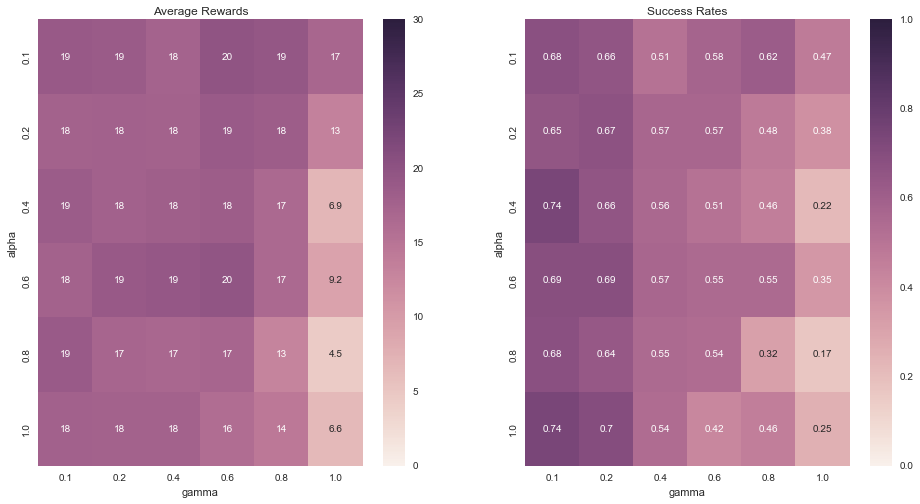

In [49]:
alpha_values = [0.1, 0.2, 0.4, 0.6, 0.8, 1.0]
gamma_values = [0.1, 0.2, 0.4, 0.6, 0.8, 1.0]
average_rewards = [[ 19.075,  18.735,  17.545,  19.91 ,  19.42 ,  17.01 ],
                   [ 17.605,  17.725,  17.64 ,  18.865,  18.385,  13.28 ],
                   [ 18.61 ,  17.77 ,  18.05 ,  18.485,  16.695,   6.865],
                   [ 17.605,  18.975,  19.32 ,  19.695,  16.615,   9.21 ],
                   [ 18.795,  17.15 ,  16.925,  17.22 ,  12.98 ,   4.515],
                   [ 17.885,  17.69 ,  17.69 ,  16.03 ,  14.475,   6.605]]
success_rates = [[ 0.68,  0.66,  0.51,  0.58,  0.62,  0.47],
                 [ 0.65,  0.67,  0.57,  0.57,  0.48,  0.38],
                 [ 0.74,  0.66,  0.56,  0.51,  0.46,  0.22],
                 [ 0.69,  0.69,  0.57,  0.55,  0.55,  0.35],
                 [ 0.68,  0.64,  0.55,  0.54,  0.32,  0.17],
                 [ 0.74,  0.7 ,  0.54,  0.42,  0.46,  0.25]]

%matplotlib inline

import matplotlib.pyplot as plt
fig,axn = plt.subplots(1, 2, figsize=(16,8))

from seaborn import heatmap
axn.flat[0] = heatmap(average_rewards,
                      xticklabels=gamma_values, yticklabels=alpha_values,
                      annot=True, ax=axn.flat[0],
                      vmin=0, vmax=30)
axn.flat[0].set(xlabel="gamma", ylabel="alpha", title="Average Rewards")

axn.flat[1] = heatmap(success_rates,
                      xticklabels=gamma_values, yticklabels=alpha_values,
                      annot=True, ax=axn.flat[1],
                      vmin=0, vmax=1)
axn.flat[1].set(xlabel="gamma", ylabel="alpha", title="Success Rates")

#### Epsilon = 0.9

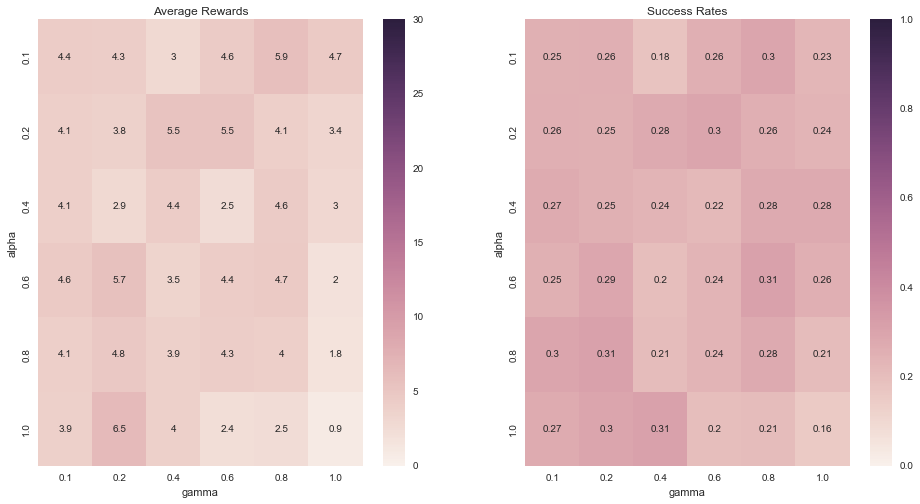

In [50]:
alpha_values = [0.1, 0.2, 0.4, 0.6, 0.8, 1.0]
gamma_values = [0.1, 0.2, 0.4, 0.6, 0.8, 1.0]
average_rewards = [[ 4.41 ,  4.32 ,  3.03 ,  4.555,  5.86 ,  4.685],
                   [ 4.125,  3.82 ,  5.47 ,  5.455,  4.145,  3.37 ],
                   [ 4.13 ,  2.9  ,  4.425,  2.5  ,  4.57 ,  3.05 ],
                   [ 4.625,  5.68 ,  3.515,  4.385,  4.675,  1.96 ],
                   [ 4.115,  4.84 ,  3.905,  4.325,  4.01 ,  1.75 ],
                   [ 3.9  ,  6.46 ,  3.97 ,  2.36 ,  2.545,  0.895]]
success_rates = [[ 0.25,  0.26,  0.18,  0.26,  0.3 ,  0.23],
                 [ 0.26,  0.25,  0.28,  0.3 ,  0.26,  0.24],
                 [ 0.27,  0.25,  0.24,  0.22,  0.28,  0.28],
                 [ 0.25,  0.29,  0.2 ,  0.24,  0.31,  0.26],
                 [ 0.3 ,  0.31,  0.21,  0.24,  0.28,  0.21],
                 [ 0.27,  0.3 ,  0.31,  0.2 ,  0.21,  0.16]]

%matplotlib inline

import matplotlib.pyplot as plt
fig,axn = plt.subplots(1, 2, figsize=(16,8))

from seaborn import heatmap
axn.flat[0] = heatmap(average_rewards,
                      xticklabels=gamma_values, yticklabels=alpha_values,
                      annot=True, ax=axn.flat[0],
                      vmin=0, vmax=30)
axn.flat[0].set(xlabel="gamma", ylabel="alpha", title="Average Rewards")

axn.flat[1] = heatmap(success_rates,
                      xticklabels=gamma_values, yticklabels=alpha_values,
                      annot=True, ax=axn.flat[1],
                      vmin=0, vmax=1)
axn.flat[1].set(xlabel="gamma", ylabel="alpha", title="Success Rates")

### Question 6:

**Does your agent get close to finding an optimal policy, i.e. reach the destination in the minimum possible time, and not incur any penalties? How would you describe an optimal policy for this problem?**

Yes. By looking at the values for Q, the optimal policy could be extracted as follow:

1. As long as the `next_waypoint` is giving a legal move (Ex: `next_waypoint = left` and `legal_left = true`), the agent follows executes the `next_waypoint` action.
2. When the `next_waypoint` is an illegal move, the agent should execute the `None` action (i.e. stay in its place)

#### Q Values from one of the runs:

Below you can find Q values from one of the run with the optimal values for `epsilon`, `alpha`, and `gamma` (0.1, 0.2, 0.4, respectively). I grouped them by state to see the Q value for each chosen action at any given state.

```
("{'light': 'green', 'next_waypoint': 'forward', 'right': 'forward', 'oncoming': None, 'left': None}", 'left') 0.208

("{'light': 'green', 'next_waypoint': 'forward', 'right': 'left', 'oncoming': 'right', 'left': None}", 'forward') 0.846

("{'light': 'green', 'next_waypoint': 'forward', 'right': 'left', 'oncoming': None, 'left': None}", 'left') 0.116

("{'light': 'green', 'next_waypoint': 'forward', 'right': 'right', 'oncoming': None, 'left': None}", 'forward') 0.694

("{'light': 'green', 'next_waypoint': 'forward', 'right': None, 'oncoming': 'forward', 'left': None}", 'forward') 0.400

("{'light': 'green', 'next_waypoint': 'forward', 'right': None, 'oncoming': 'left', 'left': None}", 'forward') 1.376

("{'light': 'green', 'next_waypoint': 'forward', 'right': None, 'oncoming': 'right', 'left': None}", 'right') 0.316

("{'light': 'green', 'next_waypoint': 'forward', 'right': None, 'oncoming': None, 'left': 'forward'}", None) 0.000
("{'light': 'green', 'next_waypoint': 'forward', 'right': None, 'oncoming': None, 'left': 'forward'}", 'forward') 0.917
("{'light': 'green', 'next_waypoint': 'forward', 'right': None, 'oncoming': None, 'left': 'forward'}", 'right') -0.100

("{'light': 'green', 'next_waypoint': 'forward', 'right': None, 'oncoming': None, 'left': 'left'}", None) 0.062
("{'light': 'green', 'next_waypoint': 'forward', 'right': None, 'oncoming': None, 'left': 'left'}", 'forward') 0.777

("{'light': 'green', 'next_waypoint': 'forward', 'right': None, 'oncoming': None, 'left': 'right'}", 'forward') 0.400
("{'light': 'green', 'next_waypoint': 'forward', 'right': None, 'oncoming': None, 'left': 'right'}", 'right') -0.100

("{'light': 'green', 'next_waypoint': 'forward', 'right': None, 'oncoming': None, 'left': None}", None) 1.416
("{'light': 'green', 'next_waypoint': 'forward', 'right': None, 'oncoming': None, 'left': None}", 'forward') 5.303
("{'light': 'green', 'next_waypoint': 'forward', 'right': None, 'oncoming': None, 'left': None}", 'left') 1.016
("{'light': 'green', 'next_waypoint': 'forward', 'right': None, 'oncoming': None, 'left': None}", 'right') 0.594

("{'light': 'green', 'next_waypoint': 'left', 'right': 'forward', 'oncoming': None, 'left': None}", 'right') 0.163

("{'light': 'green', 'next_waypoint': 'left', 'right': 'left', 'oncoming': None, 'left': None}", None) 0.000
("{'light': 'green', 'next_waypoint': 'left', 'right': 'left', 'oncoming': None, 'left': None}", 'left') 0.400

("{'light': 'green', 'next_waypoint': 'left', 'right': 'right', 'oncoming': None, 'left': None}", None) 0.000

("{'light': 'green', 'next_waypoint': 'left', 'right': None, 'oncoming': 'left', 'left': None}", 'left') 1.114

("{'light': 'green', 'next_waypoint': 'left', 'right': None, 'oncoming': None, 'left': 'forward'}", 'right') 0.390
("{'light': 'green', 'next_waypoint': 'left', 'right': None, 'oncoming': None, 'left': 'left'}", 'forward') 0.017
("{'light': 'green', 'next_waypoint': 'left', 'right': None, 'oncoming': None, 'left': 'right'}", 'left') 0.413

("{'light': 'green', 'next_waypoint': 'left', 'right': None, 'oncoming': None, 'left': None}", None) 0.489
("{'light': 'green', 'next_waypoint': 'left', 'right': None, 'oncoming': None, 'left': None}", 'forward') 0.172
("{'light': 'green', 'next_waypoint': 'left', 'right': None, 'oncoming': None, 'left': None}", 'left') 3.956
("{'light': 'green', 'next_waypoint': 'left', 'right': None, 'oncoming': None, 'left': None}", 'right') 0.424

("{'light': 'green', 'next_waypoint': 'right', 'right': 'left', 'oncoming': None, 'left': None}", 'forward') 0.325
("{'light': 'green', 'next_waypoint': 'right', 'right': None, 'oncoming': 'left', 'left': None}", None) 0.000
("{'light': 'green', 'next_waypoint': 'right', 'right': None, 'oncoming': 'left', 'left': None}", 'forward') 0.308
("{'light': 'green', 'next_waypoint': 'right', 'right': None, 'oncoming': 'left', 'left': None}", 'left') -0.100

("{'light': 'green', 'next_waypoint': 'right', 'right': None, 'oncoming': 'right', 'left': None}", 'forward') -0.087
("{'light': 'green', 'next_waypoint': 'right', 'right': None, 'oncoming': 'right', 'left': None}", 'right') 0.462

("{'light': 'green', 'next_waypoint': 'right', 'right': None, 'oncoming': None, 'left': 'forward'}", 'forward') 1.653

("{'light': 'green', 'next_waypoint': 'right', 'right': None, 'oncoming': None, 'left': 'left'}", 'right') 3.341

("{'light': 'green', 'next_waypoint': 'right', 'right': None, 'oncoming': None, 'left': None}", None) 1.120
("{'light': 'green', 'next_waypoint': 'right', 'right': None, 'oncoming': None, 'left': None}", 'forward') 0.639
("{'light': 'green', 'next_waypoint': 'right', 'right': None, 'oncoming': None, 'left': None}", 'left') 0.341
("{'light': 'green', 'next_waypoint': 'right', 'right': None, 'oncoming': None, 'left': None}", 'right') 3.386

("{'light': 'red', 'next_waypoint': 'forward', 'right': 'forward', 'oncoming': None, 'left': None}", 'right') -0.100

("{'light': 'red', 'next_waypoint': 'forward', 'right': 'left', 'oncoming': None, 'left': None}", 'forward') -0.200

("{'light': 'red', 'next_waypoint': 'forward', 'right': 'right', 'oncoming': None, 'left': None}", 'left') -0.200

("{'light': 'red', 'next_waypoint': 'forward', 'right': None, 'oncoming': 'left', 'left': None}", 'left') -0.200
("{'light': 'red', 'next_waypoint': 'forward', 'right': None, 'oncoming': 'left', 'left': None}", 'right') 0.449

("{'light': 'red', 'next_waypoint': 'forward', 'right': None, 'oncoming': 'right', 'left': None}", 'right') 0.357

("{'light': 'red', 'next_waypoint': 'forward', 'right': None, 'oncoming': None, 'left': 'forward'}", 'forward') -0.200

("{'light': 'red', 'next_waypoint': 'forward', 'right': None, 'oncoming': None, 'left': 'left'}", 'forward') -0.200

("{'light': 'red', 'next_waypoint': 'forward', 'right': None, 'oncoming': None, 'left': 'right'}", None) 0.000
("{'light': 'red', 'next_waypoint': 'forward', 'right': None, 'oncoming': None, 'left': 'right'}", 'left') -0.200

("{'light': 'red', 'next_waypoint': 'forward', 'right': None, 'oncoming': None, 'left': None}", None) 0.000
("{'light': 'red', 'next_waypoint': 'forward', 'right': None, 'oncoming': None, 'left': None}", 'forward') -0.924
("{'light': 'red', 'next_waypoint': 'forward', 'right': None, 'oncoming': None, 'left': None}", 'left') -0.804
("{'light': 'red', 'next_waypoint': 'forward', 'right': None, 'oncoming': None, 'left': None}", 'right') -0.029

("{'light': 'red', 'next_waypoint': 'left', 'right': 'left', 'oncoming': None, 'left': None}", 'forward') -0.200

("{'light': 'red', 'next_waypoint': 'left', 'right': None, 'oncoming': 'forward', 'left': None}", 'right') 0.157

("{'light': 'red', 'next_waypoint': 'left', 'right': None, 'oncoming': None, 'left': 'left'}", 'right') 0.314

("{'light': 'red', 'next_waypoint': 'left', 'right': None, 'oncoming': None, 'left': None}", None) 0.000
("{'light': 'red', 'next_waypoint': 'left', 'right': None, 'oncoming': None, 'left': None}", 'forward') -0.488
("{'light': 'red', 'next_waypoint': 'left', 'right': None, 'oncoming': None, 'left': None}", 'left') -0.893
("{'light': 'red', 'next_waypoint': 'left', 'right': None, 'oncoming': None, 'left': None}", 'right') -0.070

("{'light': 'red', 'next_waypoint': 'right', 'right': None, 'oncoming': 'forward', 'left': None}", 'forward') -0.200
("{'light': 'red', 'next_waypoint': 'right', 'right': None, 'oncoming': 'forward', 'left': None}", 'right') 0.675

("{'light': 'red', 'next_waypoint': 'right', 'right': None, 'oncoming': 'left', 'left': None}", None) 0.058
("{'light': 'red', 'next_waypoint': 'right', 'right': None, 'oncoming': 'left', 'left': None}", 'right') 1.315

("{'light': 'red', 'next_waypoint': 'right', 'right': None, 'oncoming': 'right', 'left': None}", 'left') -0.200

("{'light': 'red', 'next_waypoint': 'right', 'right': None, 'oncoming': None, 'left': 'right'}", None) 0.000

("{'light': 'red', 'next_waypoint': 'right', 'right': None, 'oncoming': None, 'left': None}", None) 0.563
{'light': 'red', 'next_waypoint': 'right', 'right': None, 'oncoming': None, 'left': None}", 'forward') 0.349
("{'light': 'red', 'next_waypoint': 'right', 'right': None, 'oncoming': None, 'left': None}", 'left') 0.467
("{'light': 'red', 'next_waypoint': 'right', 'right': None, 'oncoming': None, 'left': None}", 'right') 3.182
```

#### Comments about the Q-Values

One could see from the above that the agent is following the optimal policy I described in Question 6.

For example, in the group:
```
("{'light': 'green', 'next_waypoint': 'forward', 'right': None, 'oncoming': None, 'left': None}", None) 1.416
("{'light': 'green', 'next_waypoint': 'forward', 'right': None, 'oncoming': None, 'left': None}", 'forward') 5.303
("{'light': 'green', 'next_waypoint': 'forward', 'right': None, 'oncoming': None, 'left': None}", 'left') 1.016
("{'light': 'green', 'next_waypoint': 'forward', 'right': None, 'oncoming': None, 'left': None}", 'right') 0.594
```
The best action is to follow the planner (`next_waypoint='forward'`) because the light is green which means following the planner is allowed.

Also, from the following group:
```
("{'light': 'red', 'next_waypoint': 'left', 'right': None, 'oncoming': None, 'left': None}", None) 0.000
("{'light': 'red', 'next_waypoint': 'left', 'right': None, 'oncoming': None, 'left': None}", 'forward') -0.488
("{'light': 'red', 'next_waypoint': 'left', 'right': None, 'oncoming': None, 'left': None}", 'left') -0.893
("{'light': 'red', 'next_waypoint': 'left', 'right': None, 'oncoming': None, 'left': None}", 'right') -0.070
```
The best action is to do nothing. This is expected because the planner asks from the agent to turn left while the light is red. Therefore, the best action for the agent is to remain in its position until the light turns green and the way is open for it. Which is actually the best thing to do as shown in the following group:
```
("{'light': 'green', 'next_waypoint': 'left', 'right': None, 'oncoming': None, 'left': None}", None) 0.489
("{'light': 'green', 'next_waypoint': 'left', 'right': None, 'oncoming': None, 'left': None}", 'forward') 0.172
("{'light': 'green', 'next_waypoint': 'left', 'right': None, 'oncoming': None, 'left': None}", 'left') 3.956
("{'light': 'green', 'next_waypoint': 'left', 'right': None, 'oncoming': None, 'left': None}", 'right') 0.424
```